<link rel="preconnect" href="https://fonts.gstatic.com">
<link href="https://fonts.googleapis.com/css2?family=Fira+Code&display=swap" rel="stylesheet">

### License

<p style="font-family: 'Fira Code', monospace; font-size: 1.2rem">
Copyright 2021 Xilinx, Inc.<br><br>
Licensed under the Apache License, Version 2.0 (the "License");<br>
you may not use this file except in compliance with the License.<br><br>
You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0"?>http://www.apache.org/licenses/LICENSE-2.0</a><br><br>
Unless required by applicable law or agreed to in writing, software<br>
distributed under the License is distributed on an "AS IS" BASIS,<br>
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.<br>
See the License for the specific language governing permissions and<br>
limitations under the License.<br>
</p>


# IBERT link and eye scan example


<img src="../../img/api_overview.png" width="500" align="left">

## Description
This example shows how to interact with the IBERT (Integrated Bit Error Ratio Tester) debug core service via ChipScoPy APIs.
- Program the ChipScoPy CED design onto the XCVC1902 device on a VCK190 board
- Verify that the expected IBERT quads are instantiated by the design
- Create links and change link settings to get link lock
- Run and plot eye scans for the links


## Requirements
- Local or remote Xilinx Versal board, such as a VCK190
- Xilinx hw_server 2021.1 or greater
- Xilinx cs_server 2021.1 or greater
- Python 3.8 or greater installed
- ChipScoPy 2021.1 or greater installed
- Jupyter notebook support installed - Please do so, using the command `pip install chipscopy[jupyter]`
- Plotting support installed - Please do so, using the command `pip install chipscopy[plotly]`

## 1 - Initialization: Imports and File Paths

After this step,
- Required functions and classes are imported
- Paths to server(s) and files are set correctly

In [1]:
import os
from more_itertools import one

from chipscopy import create_session, report_versions, report_hierarchy, get_design_files
from chipscopy.api.ibert.aliases import (
    EYE_SCAN_HORZ_RANGE,
    EYE_SCAN_VERT_RANGE,
    EYE_SCAN_VERT_STEP,
    EYE_SCAN_HORZ_STEP,
    EYE_SCAN_TARGET_BER,
    PATTERN,
    RX_LOOPBACK,
)
from chipscopy.api.ibert import create_eye_scans, create_links

In [2]:
# Make sure to start the hw_server and cs_server prior to running.
# Specify locations of the running hw_server and cs_server below.
# The default is localhost - but can be other locations on the network.
CS_URL = os.getenv("CS_SERVER_URL", "TCP:localhost:3042")
HW_URL = os.getenv("HW_SERVER_URL", "TCP:localhost:3121")

# The get_design_files() function tries to find the PDI and LTX files. In non-standard
# configurations, you can put the path for PROGRAMMING_FILE and PROBES_FILE below.
design_files = get_design_files("vck190/production/chipscopy_ced")

PDI_FILE = design_files.programming_file

print(f"PROGRAMMING_FILE: {PDI_FILE}")

PROGRAMMING_FILE: C:\wrk\chipscopy\chipscopy\examples\designs\vck190\production\chipscopy_ced\chipscopy_ex_wrapper.pdi


## 2 - Create a session and connect to the hw_server and cs_server

The session is a container that keeps track of devices and debug cores.
After this step,
- Session is initialized and connected to server(s)
- Versions are detected and reported to stdout

In [3]:
session = create_session(cs_server_url=CS_URL, hw_server_url=HW_URL)
report_versions(session)

## 3 - Program the device with the example design

After this step,
- Device is programmed with the example programming file

In [4]:
# Typical case - one device on the board - get it.
device = session.devices.get()
device.program(PDI_FILE)

Output()

## 4 - Discover and setup the IBERT core

Debug core discovery initializes the chipscope server debug cores.

After this step,

- The cs_server is initialized and ready for use
- The first ibert found is used

In [5]:
device.discover_and_setup_cores(ibert_scan=True)
print("--> Debug core discovery done")

if len(device.ibert_cores) == 0:
    print("No IBERT core found! Exiting...")
    exit()

# Use the first available IBERT core from the device
ibert = device.ibert_cores.at(index=0)

if len(ibert.gt_groups) == 0:
    print("No GT Groups available for use! Exiting...")
    exit()

print(f"GT Groups available - {[gt_group_obj.name for gt_group_obj in ibert.gt_groups]}")

--> Debug core discovery done
GT Groups available - ['Quad_205', 'Quad_204', 'Quad_201', 'Quad_105']


## 5 - Print the hierarchy of the IBERT core

We also ensure that all the quads instantiated by the ChipScoPy CED design are found by the APIs

In [6]:
report_hierarchy(ibert)

assert len(ibert.gt_groups) == 4

q205 = one(ibert.gt_groups.filter_by(name="Quad_205"))
q204 = one(ibert.gt_groups.filter_by(name="Quad_204"))
q201 = one(ibert.gt_groups.filter_by(name="Quad_201"))
q105 = one(ibert.gt_groups.filter_by(name="Quad_105"))

## 6 - Create links between following TXs and RXs
- Quad 205 CH0 TX to Quad 205 CH0 RX
- Quad 204 CH1 TX to Quad 204 CH1 RX
- Quad 201 CH2 TX to Quad 201 CH2 RX
- Quad 105 CH3 TX to Quad 105 CH3 RX

In [7]:
links = create_links(
    txs=[q205.gts[0].tx, q204.gts[1].tx, q201.gts[2].tx, q105.gts[3].tx],
    rxs=[q205.gts[0].rx, q204.gts[1].rx, q201.gts[2].rx, q105.gts[3].rx],
)

print("--> Done creating links")

--> Done creating links


## 7 - Print the valid values for pattern and loopback, set the pattern for the TXs and RXs to "PRBS 31" and set loopback to "Near-End PMA"

In order to lock the internal pattern checker, TX and RX patterns need to match. We also need to have some kind of loopback, internal/external.

We are assuming that no external cable loopback is present and hence making use of internal loopback.

In [8]:
for link in links:
    print(f"\n----- {link.name} -----")
    _, tx_pattern_report = link.tx.property.report(link.tx.property_for_alias[PATTERN]).popitem()
    _, rx_pattern_report = link.rx.property.report(link.rx.property_for_alias[PATTERN]).popitem()
    _, rx_loopback_report = link.tx.property.report(
        link.rx.property_for_alias[RX_LOOPBACK]
    ).popitem()

    print(f"--> Valid values for TX pattern - {tx_pattern_report['Valid values']}")
    print(f"--> Valid values for RX pattern - {rx_pattern_report['Valid values']}")
    print(f"--> Valid values for RX loopback - {rx_loopback_report['Valid values']}")

    props = {link.tx.property_for_alias[PATTERN]: "PRBS 31"}
    link.tx.property.set(**props)
    link.tx.property.commit(list(props.keys()))

    props = {
        link.rx.property_for_alias[PATTERN]: "PRBS 31",
        link.rx.property_for_alias[RX_LOOPBACK]: "Near-End PMA",
    }
    link.rx.property.set(**props)
    link.rx.property.commit(list(props.keys()))
    print(f"\n--> Set both patterns to 'PRBS 31' & loopback to 'Near-End PMA' for {link}")

    assert link.rx.pll.locked and link.tx.pll.locked
    print(f"--> RX and TX PLLs are locked for {link}. Checking for link lock...")
    assert link.status != "No link"
    print(f"--> {link} is linked as expected")


----- Link_0 -----
--> Valid values for TX pattern - ['User Design', 'PRBS Disabled', 'PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31']
--> Valid values for RX pattern - ['User Design', 'PRBS Disabled', 'PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31']
--> Valid values for RX loopback - ['User Design', 'None', 'Near-End PCS', 'Far-End PCS', 'Near-End PMA', 'Far-End PMA']

--> Set both patterns to 'PRBS 31' & loopback to 'Near-End PMA' for Link_0
--> RX and TX PLLs are locked for Link_0. Checking for link lock...
--> Link_0 is linked as expected

----- Link_1 -----
--> Valid values for TX pattern - ['User Design', 'PRBS Disabled', 'PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31']
--> Valid values for RX pattern - ['User Design', 'PRBS Disabled', 'PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31']
--> Valid values for RX loopback - ['User Design', 'None', 'Near-End PCS', 'Far-End PCS', 'Near-End PMA', 'Far-End PMA']

--> Set both patterns to 'PRBS 31' & loopback to 'Near-End P

## 8 - Create eye scan objects for all the links, set the scan params and start the scan

The eye scans will be run in parallel

In [9]:
eye_scans = create_eye_scans(target_objs=[link for link in links])
for eye_scan in eye_scans:
    eye_scan.params[EYE_SCAN_HORZ_STEP].value = 2
    eye_scan.params[EYE_SCAN_VERT_STEP].value = 2
    eye_scan.params[EYE_SCAN_HORZ_RANGE].value = "-0.500 UI to 0.500 UI"
    eye_scan.params[EYE_SCAN_VERT_RANGE].value = "100%"
    eye_scan.params[EYE_SCAN_TARGET_BER].value = 1e-5

    eye_scan.start()
    print(f"Started eye scan {eye_scan}")

Output()

Started eye scan EyeScan_1
Started eye scan EyeScan_2
Started eye scan EyeScan_3
Started eye scan EyeScan_4


## 9 - Wait for all the eye scans to get done

In [10]:
eye_scans[0].wait_till_done()
eye_scans[1].wait_till_done()
eye_scans[2].wait_till_done()
eye_scans[3].wait_till_done()

## 10 - View Eye Scan Plot.

This requires Plotly to be installed. See how to install it [here](https://pages.gitenterprise.xilinx.com/chipscope/chipscopy/2020.2/ibert/scan.html#scan-plots)

NOTE - The plot may not display if this notebook is run in Jupyter Lab. For details, see [link](https://plotly.com/python/getting-started/#jupyterlab-support-python-35)

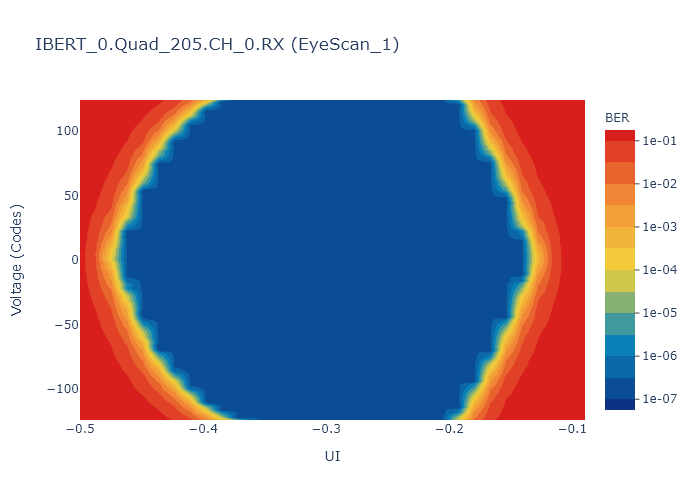

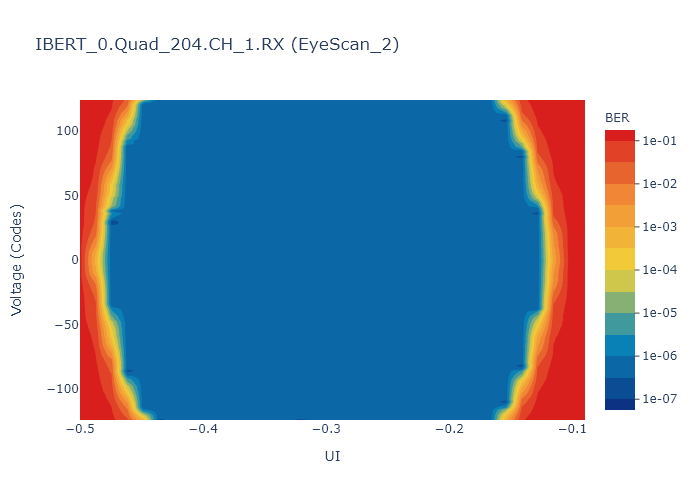

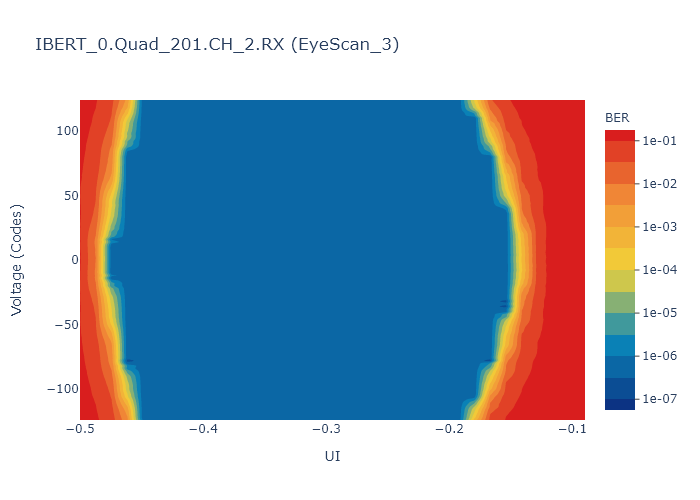

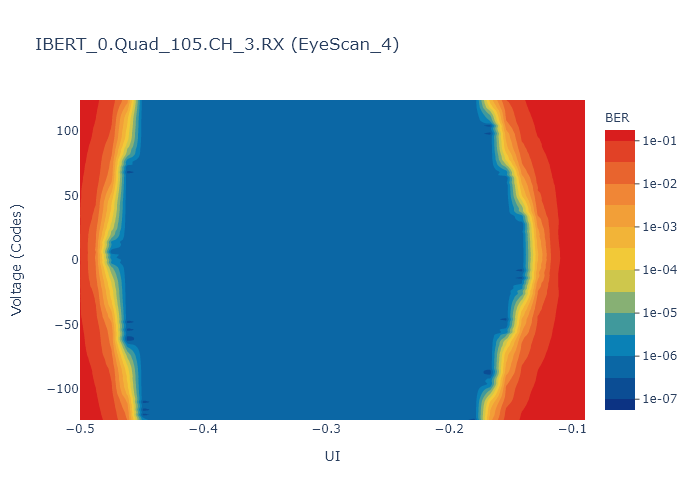

In [11]:
eye_scans[0].plot.show()
eye_scans[1].plot.show()
eye_scans[2].plot.show()
eye_scans[3].plot.show()